---
title: stata教程05-自相关的检验和处理
date: 2018-12-12 18:17:55
tags: [stata]
toc: true
mathjax: true

---

OLS回归不满足球形扰动怎么办? 模型存在自相关怎么办? 怎么检验数据是否存在自相关? 下面我们就回答这些问题。
<span></span>
<!-- more -->

### 数据介绍

以Hildreth and Lu对冰激淋需求函数的研究为例。数据集icecream.dta包含30个月度时间序列数据, 变量有: consumption(人均冰激淋的消费量), income(平均家庭收入), price(冰激淋价格), temp(平均温度), time(时间)。

### 加载数据&查看旗本情况

In [1]:
use data/icecream.dta, clear

因为是时间序列数据, 所以我们需要设置哪个变量是时间变量:

In [3]:
tsset time

        time variable:  time, 1 to 30
                delta:  1 unit


描述一下数据的基本情况:

In [4]:
describe


Contains data from data/icecream.dta
  obs:            30                          
 vars:             6                          16 Sep 2010 09:53
 size:           720                          
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
time            float   %9.0g                 
consumption     float   %9.0g                 
price           float   %9.0g                 
income          float   %9.0g                 
te

直观上, 我们可能觉得气温和冰激淋的消费量是相关的, 气温越高冰激淋的消费量可能越高, 而气温又和时间和季节有关, 所以我们可以画一个图来看下他们的情况:

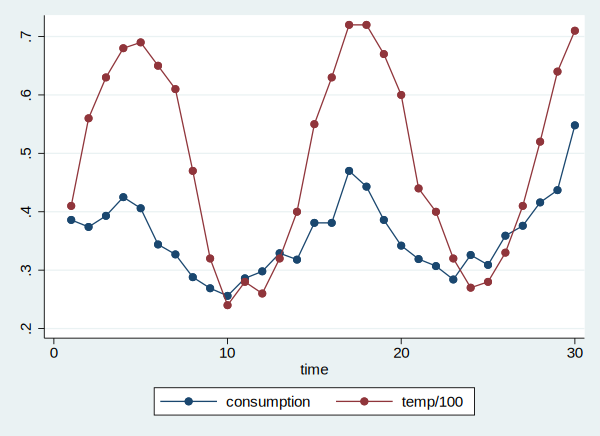

In [8]:
graph twoway connect consumption temp100 time

上面的命令解释:
    
    - graph 绘图命令
    - twoway 二维图
    - connect 折线图
    - 剩下的都是变量, 最后一个变量指的是x轴

### 回归分析

下面我们使用三个变量来预测冰激淋的消费量:

In [9]:
reg consumption temp price income


      Source |       SS           df       MS      Number of obs   =        30
-------------+----------------------------------   F(3, 26)        =     22.17
       Model |  .090250523         3  .030083508   Prob > F        =    0.0000
    Residual |  .035272835        26  .001356647   R-squared       =    0.7190
-------------+----------------------------------   Adj R-squared   =    0.6866
       Total |  .125523358        29  .004328392   Root MSE        =    .03683

------------------------------------------------------------------------------
 consumption |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        temp |   .0034584   .0004455     7.76   0.000     .0025426    .0043743
       price |  -1.044413    .834357    -1.25   0.222    -2.759458    .6706322
      income |   .0033078   .0011714     2.82   0.009     .0008999    .0057156
       _cons |   .1973149   .2702161     0.73   0.

结果现实temp和income的系数都是显著的, 但是因为这是时间序列数据, 我们需要检验是否存在自相关。

### 自相关的检验

#### 绘制残差和滞后残差的散点图

计算残差

In [10]:
predict e1 ,res

计算残差的1阶滞后

In [ ]:
g e2 = L.e1

绘制散点图(scatter), 绘制线性拟合曲线(lfit)

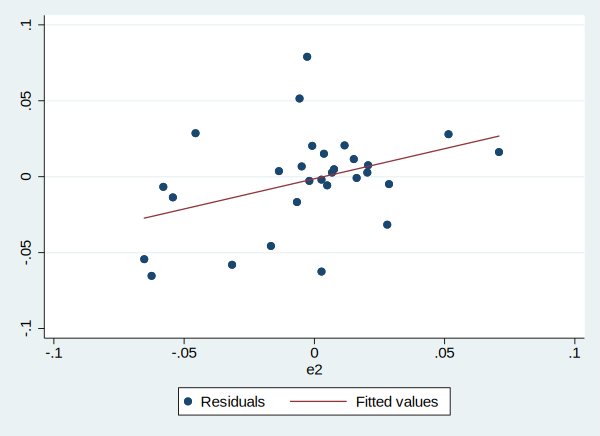

In [13]:
twoway (scatter e1 e2) (lfit e1 e2)

#### 自相关图

自相关图指的是变量和变量的n阶滞后的相关, 我们通常查看自相关图来决定自相关的阶数:

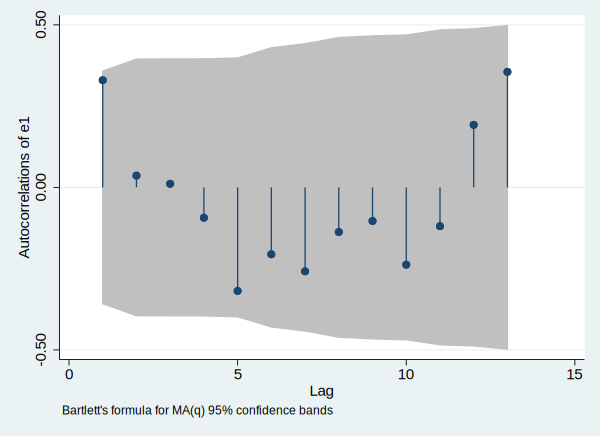

In [14]:
ac e1

这个图的x轴指的是滞后阶数n, y轴指的是自相关系数的大小, 我们可以从图中看到, 自相关主要是1阶, 因为2/3/4阶的相关都比较小, 而更高阶的相关基本不考虑。

#### 偏自相关图

我们还可以查看偏自相关图:

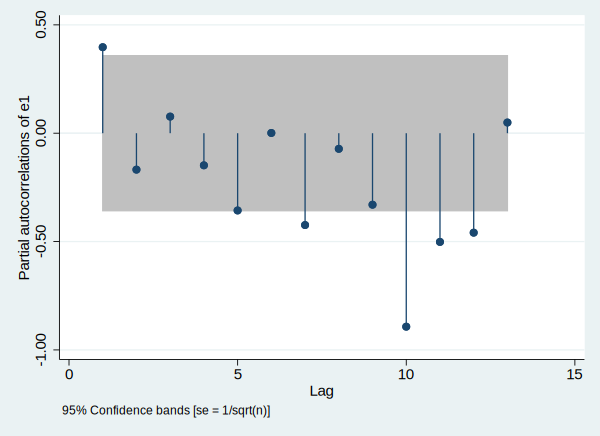

In [15]:
pac e1

#### BT检验

In [16]:
estat bgodfrey


Breusch-Godfrey LM test for autocorrelation
---------------------------------------------------------------------------
    lags(p)  |          chi2               df                 Prob > chi2
-------------+-------------------------------------------------------------
       1     |          4.237               1                   0.0396
---------------------------------------------------------------------------
                        H0: no serial correlation


p值小于0.05, 可以拒绝虚无假设: 不存在自相关。

#### Q检验

再来做一下Q检验:

In [17]:
wntestq e1


Portmanteau test for white noise
---------------------------------------
 Portmanteau (Q) statistic =    26.1974
 Prob > chi2(13)           =     0.0160


Q检验的结果同样显示存在着自相关。

### 异方差自相关稳健的标准误(HAC)

该方法需要提前确定Newey-West估计量的滞后阶数p, 一般公式是$p=n^{1/4}$ 或者 $p=0.75n^{1/3}$。本例中, n=30, 因此可以计算得到p=3。

In [18]:
newey consumption temp price income, lag(3)


Regression with Newey-West standard errors      Number of obs     =         30
maximum lag: 3                                  F(  3,        26) =      27.63
                                                Prob > F          =     0.0000

------------------------------------------------------------------------------
             |             Newey-West
 consumption |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        temp |   .0034584   .0004002     8.64   0.000     .0026357    .0042811
       price |  -1.044413   .9772494    -1.07   0.295    -3.053178    .9643518
      income |   .0033078   .0013278     2.49   0.019     .0005783    .0060372
       _cons |   .1973149   .3378109     0.58   0.564    -.4970655    .8916952
------------------------------------------------------------------------------


结果显示, Newey-West的标准误与OLS标准误相差无几, 所以我们的结果基本没有变化。同时我们考虑p取不同的值会不会导致结果发生变化, 以便考察统计量对p的稳健性。

In [19]:
newey consumption temp price income, lag(6)


Regression with Newey-West standard errors      Number of obs     =         30
maximum lag: 6                                  F(  3,        26) =      52.97
                                                Prob > F          =     0.0000

------------------------------------------------------------------------------
             |             Newey-West
 consumption |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        temp |   .0034584   .0003504     9.87   0.000     .0027382    .0041787
       price |  -1.044413   .9821798    -1.06   0.297    -3.063313    .9744864
      income |   .0033078     .00132     2.51   0.019     .0005945     .006021
       _cons |   .1973149   .3299533     0.60   0.555    -.4809139    .8755437
------------------------------------------------------------------------------


结果显示, 统计量没有太大变化, 说明HAC还算稳健。

### 广义最小二乘法(FGLS)

广义最小二乘法在具体实现细节上又可以分为几种方法, 这里我们演示一下CO(Cochrane-Orcutt)和PW(Prais and Winsten)估计法。

#### CO估计法

In [20]:
prais consumption temp price income, corc


Iteration 0:  rho = 0.0000
Iteration 1:  rho = 0.4006
Iteration 2:  rho = 0.4008
Iteration 3:  rho = 0.4009
Iteration 4:  rho = 0.4009
Iteration 5:  rho = 0.4009
Iteration 6:  rho = 0.4009
Iteration 7:  rho = 0.4009

Cochrane-Orcutt AR(1) regression -- iterated estimates

      Source |       SS           df       MS      Number of obs   =        29
-------------+----------------------------------   F(3, 25)        =     15.40
       Model |  .047040596         3  .015680199   Prob > F        =    0.0000
    Residual |  .025451894        25  .001018076   R-squared       =    0.6489
-------------+----------------------------------   Adj R-squared   =    0.6068
       Total |  .072492491        28  .002589018   Root MSE        =    .03191

------------------------------------------------------------------------------
 consumption |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        temp |

在结果的最后输出了DW值, DW估计量是评价是否存在自相关的, 由于DW初始值为1.02, 离2很远, 可以认为存在自相关, 然后再采用了CO估计法后, DW值改进为1.5。

#### PW估计法 

In [23]:
prais consumption temp price income, nolog



Prais-Winsten AR(1) regression -- iterated estimates

      Source |       SS           df       MS      Number of obs   =        30
-------------+----------------------------------   F(3, 26)        =     14.35
       Model |   .04494596         3  .014981987   Prob > F        =    0.0000
    Residual |  .027154354        26  .001044398   R-squared       =    0.6234
-------------+----------------------------------   Adj R-squared   =    0.5799
       Total |  .072100315        29  .002486218   Root MSE        =    .03232

------------------------------------------------------------------------------
 consumption |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        temp |   .0029541   .0007109     4.16   0.000     .0014929    .0044152
       price |  -1.048854    .759751    -1.38   0.179    -2.610545    .5128361
      income |  -.0008022   .0020458    -0.39   0.698    -.0050074    .003

参数nolog表示不显示迭代过程, 上表的结果显示, 收入income的系数变成了负数, 并且统计上不显著。

#### 增加解释变量

前面提到, 自相关可能是因为模型设定不正确, 我们可以考虑增加解释变量, 下面我们增加temp变量的滞后值, 然后进行OLS回归:

In [24]:
reg consumption temp L.temp price income


      Source |       SS           df       MS      Number of obs   =        29
-------------+----------------------------------   F(4, 24)        =     28.98
       Model |  .103387183         4  .025846796   Prob > F        =    0.0000
    Residual |  .021406049        24  .000891919   R-squared       =    0.8285
-------------+----------------------------------   Adj R-squared   =    0.7999
       Total |  .124793232        28  .004456901   Root MSE        =    .02987

------------------------------------------------------------------------------
 consumption |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        temp |
         --. |   .0053321   .0006704     7.95   0.000     .0039484    .0067158
         L1. |  -.0022039   .0007307    -3.02   0.006    -.0037119   -.0006959
             |
       price |  -.8383021   .6880205    -1.22   0.235    -2.258307    .5817025
      income |   .00

结果显示气温的滞后项的系数为负数, 并且是显著的, 这说明气温的滞后项越高冰激淋的消费量反而越低, 我还不能理解这其中的意义。不过, 我们下面再检验一下模型是否存在自相关的现象。

In [25]:
estat bgodfrey


Breusch-Godfrey LM test for autocorrelation
---------------------------------------------------------------------------
    lags(p)  |          chi2               df                 Prob > chi2
-------------+-------------------------------------------------------------
       1     |          0.120               1                   0.7292
---------------------------------------------------------------------------
                        H0: no serial correlation


结果显示, 自相关已经不存在了。

### 结论

好了上面就是我们检查自相关/解决自相关的方法, 至于为什么使用多种方法主要是为了检验你的结论是否具有方法的稳健性, 如果不同方法出现相互矛盾的结果, 我们可以列出是所有的结果, 然后做出自己的分析。